In [1]:
import numpy as np
import torch
import pyepo

Auto-Sklearn cannot be imported.


### Number of Cores 

In [2]:
# number of cores
cores = [1, 2, 4, 8, 16]

### Training 

In [3]:
import copy
import time
from tqdm import tqdm

from func import exactConeAlignedCosine

def pipeline(init_reg, optmodel, dataloader):
    elapsed_grb, elapsed_clb, elapsed_nnls = [], [], []
    for processes in cores:
        # set random seed
        np.random.seed(42)
        torch.manual_seed(42)
        # copy predictor
        reg = copy.deepcopy(init_reg)
        # init loss with gurobi
        time.sleep(1)
        print("Gurobi:")
        elapsed = trainingProcess(optmodel, "gurobi", processes, dataloader)
        elapsed_grb.append(elapsed)
        # init loss with clarabel
        time.sleep(1)
        print("Clarabel:")
        elapsed = trainingProcess(optmodel, "clarabel", processes, dataloader)
        elapsed_clb.append(elapsed)
        # init loss with nnls
        time.sleep(1)
        print("NNLS:")
        # train
        elapsed = trainingProcess(optmodel, "nnls", processes, dataloader)
        elapsed_nnls.append(elapsed)
    return elapsed_grb, elapsed_clb, elapsed_nnls


def trainingProcess(optmodel, solver, processes, dataloader):
    ca_cos = exactConeAlignedCosine(optmodel, solver=solver, processes=processes)
    elapsed = train(reg, ca_cos, dataloader)
    #if processes > 1:
    #    ca_cos.pool.close()
    #    ca_cos.pool.join()
    return elapsed

        
def train(reg, loss_func, dataloader):
    # set optimizer
    optimizer = torch.optim.Adam(reg.parameters(), lr=5e-2)
    # training
    tbar = tqdm(dataloader)
    tick = time.time()
    for data in tbar:
        # forward pass
        x, _, _, t_ctr = data
        # predict
        cp = reg(x)
        # loss
        loss = loss_func(cp, t_ctr)
        # backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        tbar.set_description("Loss: {:8.4f}".format(loss.item()))
    # record time
    tock = time.time()
    elapsed = tock - tick
    return elapsed

### Plot

In [4]:
from matplotlib import pyplot as plt
import tol_colors as tc

def plot(cores, elapsed_grb, elapsed_clb, elapsed_nnls, title):
    # color map
    cset =  tc.tol_cset('light')
    fig = plt.figure(figsize=(16,8))
    plt.plot(cores, elapsed_grb, marker="o", linestyle="--", markersize=10, lw=5, color=cset.orange, label="Gurobi")
    plt.plot(cores, elapsed_clb, marker="o", linestyle="--", markersize=10, lw=5, color=cset.light_blue, label="Clarabel")
    plt.plot(cores, elapsed_nnls, marker="o", linestyle="--", markersize=10, lw=5, color=cset.mint, label="NNLS")
    plt.xlabel("Num of Cores", fontsize=36)
    plt.ylabel("Runtime per Epoch (Sec)", fontsize=36)
    plt.xticks(ticks=cores, fontsize=28)
    plt.yticks(fontsize=28)
    plt.legend(fontsize=32)
    plt.title(title, fontsize=36)
    plt.show()

### Shortest Path

In [5]:
# generate data
grid = (5,5) # grid size
num_data = 1000 # number of training data
num_feat = 5 # size of feature
deg = 4 # polynomial degree
e = 0.5 # noise width
feats, costs = pyepo.data.shortestpath.genData(num_data, num_feat, grid, deg, e, seed=42)

In [6]:
from pyepo.model.grb import shortestPathModel
# set solver
optmodel = shortestPathModel(grid)
# test
optmodel.setObj(costs[0])
sol, obj = optmodel.solve()
print("Obj: {}".format(obj))
for i, e in enumerate(optmodel.arcs):
    if sol[i] > 1e-3:
        print(e)

Set parameter Username
Academic license - for non-commercial use only - expires 2024-10-22
Obj: 4.3363291797418615
(0, 1)
(1, 6)
(6, 7)
(7, 12)
(12, 17)
(17, 18)
(18, 19)
(19, 24)


In [7]:
from dataset import optDatasetConstrs
dataset_train = optDatasetConstrs(optmodel, feats, costs=costs)

Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 405.67it/s]


In [8]:
# get data loader
from torch.utils.data import DataLoader
batch_size = 32
loader_train = DataLoader(dataset_train, batch_size=batch_size, shuffle=True)

In [9]:
import torch
from torch import nn

# build linear model
class LinearRegression(nn.Module):

    def __init__(self):
        super(LinearRegression, self).__init__()
        self.linear = nn.Linear(num_feat, (grid[0]-1)*grid[1]+(grid[1]-1)*grid[0])

    def forward(self, x):
        out = self.linear(x)
        return out
    
# init model
reg = LinearRegression()

In [10]:
elapsed_grb, elapsed_clb, elapsed_nnls = pipeline(reg, optmodel, loader_train)

Gurobi:
Num of cores: 1


Loss:  -0.9999: 100%|██████████████████████████████████████████████████████████████████| 32/32 [00:05<00:00,  5.48it/s]


Clarabel:
Num of cores: 1


Loss:  -0.9998: 100%|██████████████████████████████████████████████████████████████████| 32/32 [00:06<00:00,  4.93it/s]


NNLS:
Num of cores: 1


Loss:  -0.9997: 100%|██████████████████████████████████████████████████████████████████| 32/32 [00:00<00:00, 77.22it/s]


Gurobi:
Num of cores: 2


Loss:  -0.9999: 100%|██████████████████████████████████████████████████████████████████| 32/32 [00:06<00:00,  4.66it/s]


Clarabel:
Num of cores: 2


Loss:  -0.9999: 100%|██████████████████████████████████████████████████████████████████| 32/32 [00:03<00:00,  8.64it/s]


NNLS:
Num of cores: 2


Loss:  -0.9999: 100%|██████████████████████████████████████████████████████████████████| 32/32 [00:00<00:00, 57.53it/s]


Gurobi:
Num of cores: 4


Loss:  -1.0000: 100%|██████████████████████████████████████████████████████████████████| 32/32 [00:05<00:00,  5.57it/s]


Clarabel:
Num of cores: 4


Loss:  -1.0000: 100%|██████████████████████████████████████████████████████████████████| 32/32 [00:02<00:00, 13.94it/s]


NNLS:
Num of cores: 4


Loss:  -0.9999: 100%|██████████████████████████████████████████████████████████████████| 32/32 [00:00<00:00, 42.44it/s]


Gurobi:
Num of cores: 8


Loss:  -1.0000: 100%|██████████████████████████████████████████████████████████████████| 32/32 [00:06<00:00,  4.91it/s]


Clarabel:
Num of cores: 8


Loss:  -1.0000: 100%|██████████████████████████████████████████████████████████████████| 32/32 [00:01<00:00, 20.29it/s]


NNLS:
Num of cores: 8


Loss:  -0.9999: 100%|██████████████████████████████████████████████████████████████████| 32/32 [00:01<00:00, 28.07it/s]


Gurobi:
Num of cores: 16


Loss:  -1.0000: 100%|██████████████████████████████████████████████████████████████████| 32/32 [00:17<00:00,  1.86it/s]


Clarabel:
Num of cores: 16


Loss:  -1.0000: 100%|██████████████████████████████████████████████████████████████████| 32/32 [00:01<00:00, 16.26it/s]


NNLS:
Num of cores: 16


Loss:  -1.0000: 100%|██████████████████████████████████████████████████████████████████| 32/32 [00:01<00:00, 27.89it/s]


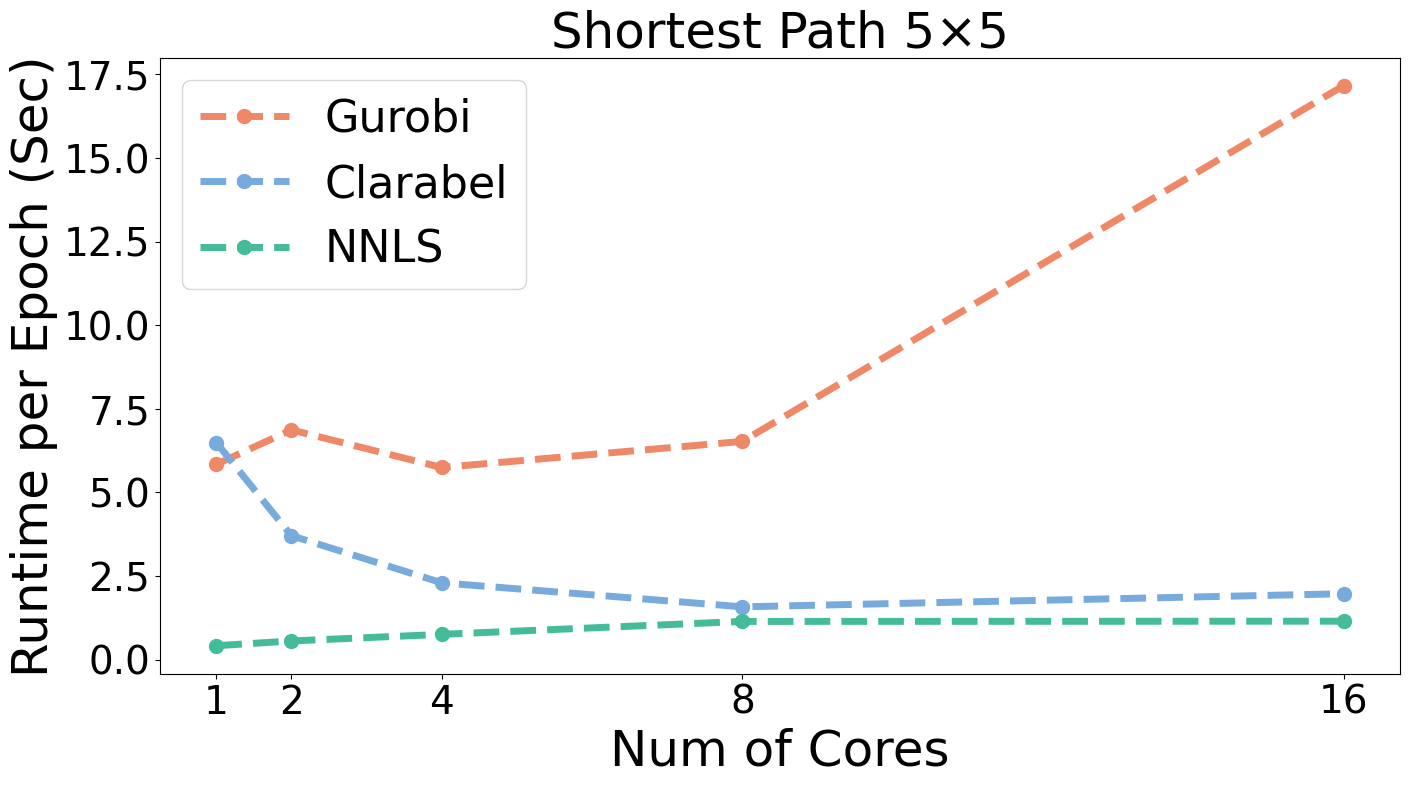

In [11]:
plot(cores, elapsed_grb, elapsed_clb, elapsed_nnls, "Shortest Path 5×5")